# Community Detection in FriendFeed Network

This notebook focuses on preparing the graph for detecting communities within the FriendFeed social network. 

We'll use the preprocessed datasets to build a graph and analyze community structures.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import gc
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import warnings
from collections import Counter
import time
from community import community_louvain
from collections import defaultdict

%matplotlib inline
sns.set(style='whitegrid')

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
start_time = time.time()

In [2]:
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

In [3]:
# Get the unique user IDs from both dataframes
user_ids_in_likes = set(likes['userID'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_likes - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'likes' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'likes' but not in 'users': 0


In [4]:
# Get the unique user IDs from both dataframes
user_ids_in_entries = set(entries['PostedBy'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_entries - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'entries' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'entries' but not in 'users': 0


In [5]:
# sizes of each dataframe
print('users:', users.shape)
print('subs:', subs.shape)
print('following:', following.shape)
print('comments:', comments.shape)
print('likes:', likes.shape)
print('entries:', entries.shape)

users: (645414, 4)
subs: (24761879, 2)
following: (18477145, 3)
comments: (2835155, 6)
likes: (427214, 3)
entries: (10954103, 5)


In [6]:
# length of unique users
print('df: users')
print(users.columns)
print('unique users:', len(users['ID'].unique()))
print('----------------------------\n')

print('df: subs')
print(subs.columns)
print('unique subs:', len(subs['FollowerID'].unique()))
print('unique subs:', len(subs['FollowedID'].unique()))
print('----------------------------\n')

print('df: following')
print(following.columns)
print('unique following:', len(following['FollowerID'].unique()))
print('unique following:', len(following['FollowedID'].unique()))
print('----------------------------\n')

print('df: comments')
print(comments.columns)
print('unique comments:', len(comments['PostedBy'].unique()))
print('----------------------------\n')

print('df: likes')
print(likes.columns)
print('unique likes:', len(likes['userID'].unique()))
print('----------------------------\n')

print('df: entries')
print(entries.columns)
print('unique entries:', len(entries['PostedBy'].unique()))

df: users
Index(['ID', 'Type', 'Name', 'Description'], dtype='object')
unique users: 645414
----------------------------

df: subs
Index(['FollowerID', 'FollowedID'], dtype='object')
unique subs: 525824
unique subs: 527108
----------------------------

df: following
Index(['FollowerID', 'FollowedID', 'Timestamp'], dtype='object')
unique following: 196436
unique following: 443552
----------------------------

df: comments
Index(['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique comments: 40919
----------------------------

df: likes
Index(['userID', 'PostID', 'Timestamp'], dtype='object')
unique likes: 13308
----------------------------

df: entries
Index(['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique entries: 209716


## 2. Build the Network Graph

We'll create a directed graph where nodes represent users, and edges represent different types of interactions such as follows, likes, and comments.

In [7]:
%%time
# Initialize directed graph
G = nx.DiGraph()

# Define relationship weights
relationship_weights = {
    'following': 1,
    'subscribe': 1,
    'like': 0.5,
    'comment': 3
}

# Add nodes for users
G.add_nodes_from(users['ID'])

# Display basic graph information
print(f"Graph has {G.number_of_nodes()}")

Graph has 645414
CPU times: user 512 ms, sys: 50.7 ms, total: 563 ms
Wall time: 609 ms


In [8]:
# Get the list of node names
node_names = list(G.nodes())
# Create a DataFrame from the node names
df = pd.DataFrame(node_names, columns=['NodeName'])

# Count duplicates
duplicate_counts = df['NodeName'].value_counts()

# Identify and display duplicates
duplicates = duplicate_counts[duplicate_counts > 1]

if not duplicates.empty:
    print("Duplicate node names found:")
    print(duplicates)
else:
    print("All node names are unique.")

All node names are unique.


In [10]:
# Function to add or update edge weights in the graph
def add_weighted_edge(graph, u, v, weight):
    if graph.has_edge(u, v):
        graph[u][v]['weight'] += weight
    else:
        graph.add_edge(u, v, weight=weight)

In [10]:
post_author_entries = pd.Series(entries['PostedBy'].values, index=entries['PostID']).to_dict()
post_author_comments = pd.Series(comments['PostedBy'].values, index=comments['PostID']).to_dict()
post_owner_mapping = {**post_author_entries, **post_author_comments}

###  Adding edges based on following

In [11]:
# Add 'following' edges
for _, row in following.iterrows():
    u, v = row['FollowerID'], row['FollowedID']
    add_weighted_edge(G, u, v, relationship_weights['following'])
    
# Display basic graph information
print(f"DiGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

DiGraph has 645414 nodes and 18477145 edges


###  Adding edges based on subs

In [12]:
# Add 'subscribe' edges
for _, row in subs.iterrows():
    u, v = row['FollowerID'], row['FollowedID']
    add_weighted_edge(G, u, v, relationship_weights['subscribe'])
    
# Display basic graph information
print(f"DiGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

DiGraph has 645414 nodes and 39380139 edges


###  Adding edges based on likes

In [13]:
# Add 'like' edges
for _, row in likes.iterrows():
    user_id = row['userID']
    post_id = row['PostID']
    if post_id in post_owner_mapping:
        post_owner = post_owner_mapping[post_id]
        add_weighted_edge(G, user_id, post_owner, relationship_weights['like'])

# Display basic graph information
print(f"DiGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

DiGraph has 645414 nodes and 39431538 edges


###  Adding edges based on comment

In [14]:
# Add 'comment' edges
for _, row in comments.iterrows():
    commenter = row['PostedBy']
    entry_id = row['EntryID']
    if entry_id in post_author_entries:
        post_owner = post_author_entries[entry_id]
        add_weighted_edge(G, commenter, post_owner, relationship_weights['comment'])
        
# Display basic graph information
print(f"DiGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

DiGraph has 645414 nodes and 39562155 edges


### Removing self-loops

In [15]:
# Remove self-loops if necessary
self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)
print(f"DiGraph after removing self-loops has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

DiGraph after removing self-loops has 645414 nodes and 39527559 edges


In [15]:
print(input('Until here ....'))

Until here .... 


In [16]:
# Get the degree of each node (the number of edges connected to each node)
degree_counts = dict(G.degree())

# Prepare a list of degree values
degree_values = list(degree_counts.values())

# Count the frequency of each degree value
degree_distribution = Counter(degree_values)

# Display the number of nodes for each degree (0 edges, 1 edge, 2 edges, etc.)
# for degree, count in sorted(degree_distribution.items()):
    # print(f"Nodes with {degree} edges: {count}")

# Calculate min, max, average, and median of the degree values
min_degree = np.min(degree_values)
max_degree = np.max(degree_values)
average_degree = np.mean(degree_values)
median_degree = np.median(degree_values)

# Count the number of nodes with min and max edges
min_degree_count = degree_distribution[min_degree]
max_degree_count = degree_distribution[max_degree]

# Print statistics
print(f"\nMinimum degree: {min_degree} (Nodes: {min_degree_count})")
print(f"Maximum degree: {max_degree} (Nodes: {max_degree_count})")
print(f"Average degree: {average_degree:.2f}")
print(f"Median degree: {median_degree}")


Minimum degree: 0 (Nodes: 2045)
Maximum degree: 178290 (Nodes: 1)
Average degree: 122.49
Median degree: 9.0


### Plot samples from the network

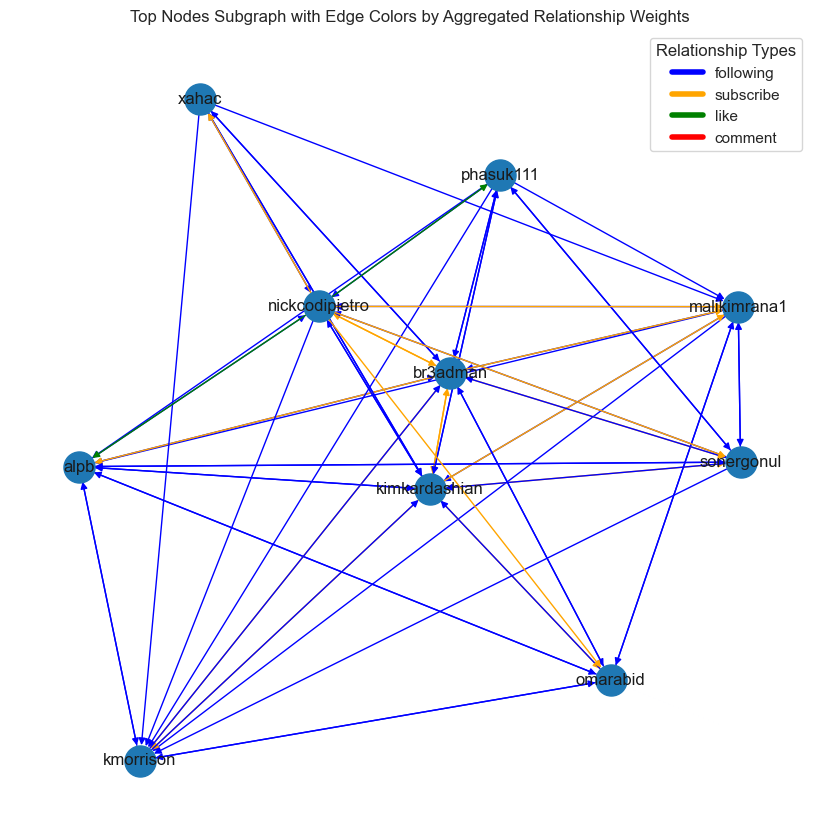

In [21]:
# Step 1: Specify the number of nodes to sample based on the most connections (highest degree)
num_nodes_to_sample = 10  # Set your desired number of nodes

# Get the degrees of all nodes (degree is the number of edges connected to a node)
node_degrees = dict(G.degree())

# Sort nodes by degree in descending order and select the top ones
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]

# Step 2: Create a subgraph from the sampled nodes
G_sampled = G.subgraph(sampled_nodes).copy()

# Step 3: Prepare edge colors based on weights
edge_colors = []
for _, _, data in G_sampled.edges(data=True):
    weight = data['weight']
    if weight <= 1:
        edge_colors.append('blue')  # Lower weight, likely 'following'
    elif 1 < weight <= 2:
        edge_colors.append('orange')  # Medium weight, likely 'subscribe'
    elif 2 < weight <= 3:
        edge_colors.append('green')  # Higher weight, likely 'like'
    else:
        edge_colors.append('red')  # Highest weight, likely 'comment'

# Step 4: Plot the sampled subgraph with colored edges
plt.figure(figsize=(8, 8))  # Adjust plot size as needed
pos = nx.spring_layout(G_sampled, seed=42)  # Using spring layout for better visualization
nx.draw(G_sampled, pos, node_size=500, edge_color=edge_colors, with_labels=True)

# Step 5: Create a legend for the edge colors
colors = {
    'following': 'blue', 
    'subscribe': 'orange', 
    'like': 'green', 
    'comment': 'red'
}

# Add custom legend entries
for relationship, color in colors.items():
    plt.plot([], [], color=color, label=relationship, linewidth=4)

plt.title('Top Nodes Subgraph with Edge Colors by Aggregated Relationship Weights')
plt.legend(title='Relationship Types', loc='upper right', bbox_to_anchor=(1, 1))
plt.show()


In [17]:
# Create a list of tuples (node, degree) and sort by degree in descending order
num_nodes_to_sample = 10
sorted_nodes_with_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes_to_sample]

# Display the sorted nodes with their degrees
for node, degree in sorted_nodes_with_degrees:
    print(f"Node: {node}, Degree: {degree}")

Node: br3adman, Degree: 178290
Node: malikimrana1, Degree: 166401
Node: sonergonul, Degree: 159404
Node: phasuk111, Degree: 159201
Node: omarabid, Degree: 143402
Node: xahac, Degree: 133903
Node: alpb, Degree: 109659
Node: nickcodipietro, Degree: 108929
Node: kimkardashian, Degree: 102528
Node: kmorrison, Degree: 102211


In [18]:
# Free up the memory
del users, subs, following, comments, likes, entries
gc.collect()

7898

### TEST, run louvain 

In [21]:
%%time
# Step 1: Apply the Louvain method
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)

CPU times: user 21min 48s, sys: 7.04 s, total: 21min 55s
Wall time: 21min 55s


In [22]:
# Add community information as node attribute
nx.set_node_attributes(G, partition, 'community')

In [23]:
# Step 2: Get the community information
# This creates a dictionary where keys are node ids and values are the community they belong to
print(f"Number of communities detected: {len(set(partition.values()))}")

Number of communities detected: 6550


### Save the network

In [24]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print graph information
print(f"Graph type: {type(G)}")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Graph type: <class 'networkx.classes.digraph.DiGraph'>
Number of nodes: 645414
Number of edges: 39527559


In [31]:
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60) 
print(f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds")

Execution time: 0 minutes and 28.37 seconds


In [32]:
%%time
# Step 3: Print the sizes of each community
community_sizes = {k: list(partition.values()).count(k) for k in set(partition.values())}
i = 0
for community, size in community_sizes.items():
    print(f"Community {community}: {size} nodes")
    i += 1
    if i == 7:
        break

Community 0: 2 nodes
Community 1: 195363 nodes
Community 2: 1134 nodes
Community 3: 12776 nodes
Community 4: 58269 nodes
Community 5: 17722 nodes
Community 6: 77162 nodes
CPU times: user 1min, sys: 5.02 ms, total: 1min
Wall time: 1min


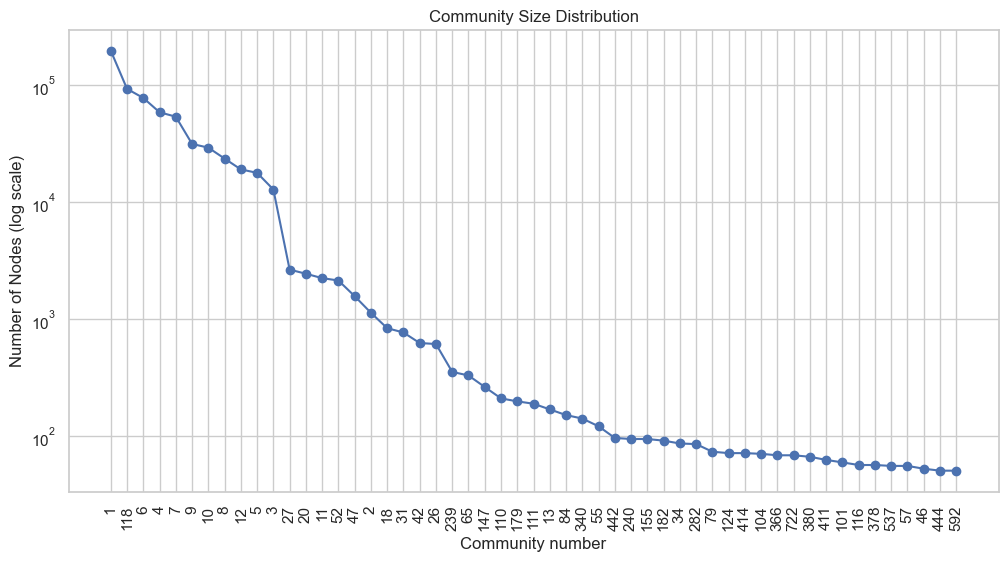

In [33]:
# Calculate size of each community
community_sizes = pd.Series(list(partition.values())).value_counts()

# Filter out communities with more than 100 users
community_sizes = community_sizes[community_sizes > 50]

# Plot the distribution as a line plot
plt.figure(figsize=(12, 6))
plt.plot(community_sizes.values, marker='o', linestyle='-', color='b')
plt.title('Community Size Distribution')
plt.xlabel('Community number')
plt.ylabel('Number of Nodes (log scale)')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Customize x-axis to show every community (community ID as the label)
plt.xticks(ticks=range(len(community_sizes)), labels=community_sizes.index, rotation=90)

plt.show()


In [34]:
# Calculate community sizes
community_sizes = {k: list(partition.values()).count(k) for k in set(partition.values())}

# Sort the communities by size in descending order and take the top 10 largest
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:15]

# Print the top 10 largest communities
for community, size in sorted_communities:
    print(f"Community {community}: {size} nodes")


Community 1: 195363 nodes
Community 118: 92213 nodes
Community 6: 77162 nodes
Community 4: 58269 nodes
Community 7: 53387 nodes
Community 9: 31278 nodes
Community 10: 29064 nodes
Community 8: 23455 nodes
Community 12: 18957 nodes
Community 5: 17722 nodes
Community 3: 12776 nodes
Community 27: 2648 nodes
Community 20: 2442 nodes
Community 11: 2240 nodes
Community 52: 2138 nodes


### Approach 1: Plotting only the largest or smallest communities

In [53]:
# Filter communities: Only include those with 100 or more members

def plot_communities_more_or_less_than(member_size, less_or_more='more'):
    if less_or_more == 'less':
        filtered_communities = {comm: size for comm, size in community_sizes.items() if size < member_size}
    else:
        filtered_communities = {comm: size for comm, size in community_sizes.items() if size > member_size}

    filtered_community_ids = set(filtered_communities.keys())
    print(f'Number of communities {less_or_more} than {member_size} memebers is: {len(filtered_communities)}')
    
    # Create a metagraph where each node represents a filtered community
    metagraph = nx.Graph()
    
    # Add nodes to the metagraph representing each filtered community
    for community_id in filtered_community_ids:
        metagraph.add_node(community_id, size=filtered_communities[community_id])
    
    # Add edges between filtered communities if nodes in different communities are connected
    for u, v in G_undirected.edges():
        comm_u = partition[u]
        comm_v = partition[v]
        if comm_u in filtered_community_ids and comm_v in filtered_community_ids and comm_u != comm_v:
            if metagraph.has_edge(comm_u, comm_v):
                metagraph[comm_u][comm_v]['weight'] += 0.02
            else:
                metagraph.add_edge(comm_u, comm_v, weight=1)
    
    # Plot the filtered metagraph
    plt.figure(figsize=(6, 6))
    pos = nx.nx_pydot.graphviz_layout(metagraph)  # Layout for better visualization
    sizes = [metagraph.nodes[comm]['size'] * 0.03 for comm in metagraph.nodes()]  # Scale the node size by community size
    nx.draw(metagraph, pos, node_size=sizes, with_labels=True, font_size=8, node_color='lightgreen')
    plt.title(f"Metagraph of Communities with {less_or_more} than {member_size} Members")
    plt.show()


Number of communities less than 2 memebers is: 2045


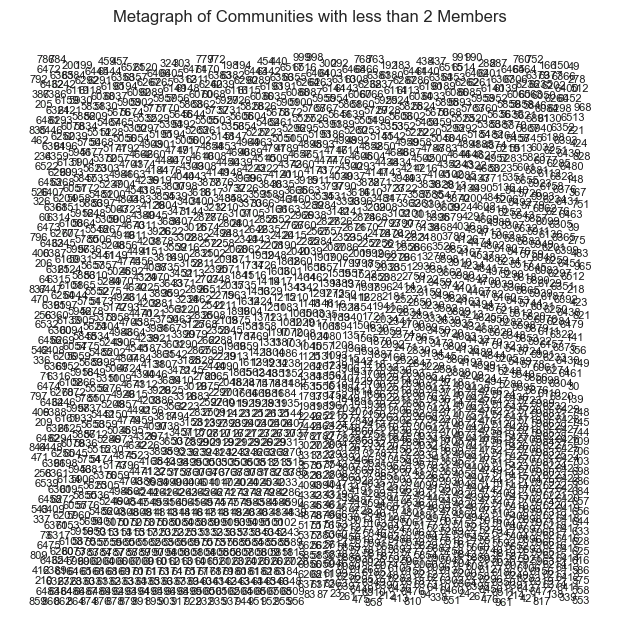

In [54]:
plot_communities_more_or_less_than(2, 'less')

Number of communities more than 100 memebers is: 31


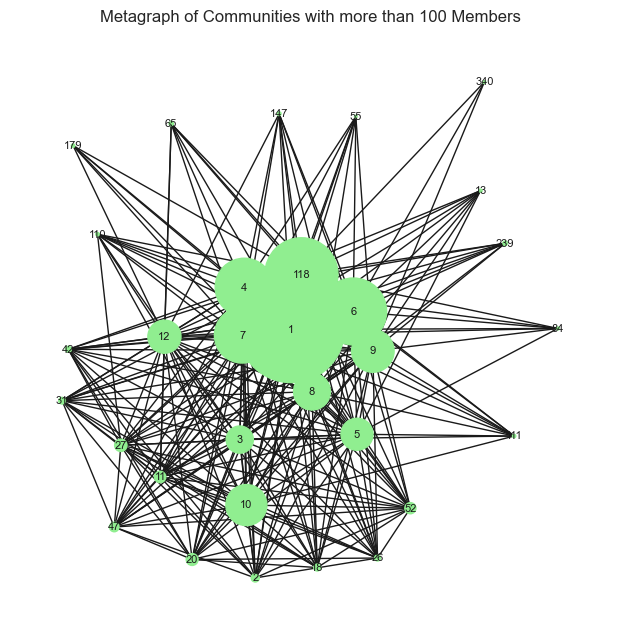

In [55]:
plot_communities_more_or_less_than(100, 'more')

Number of communities with 1000 memebers is: 17


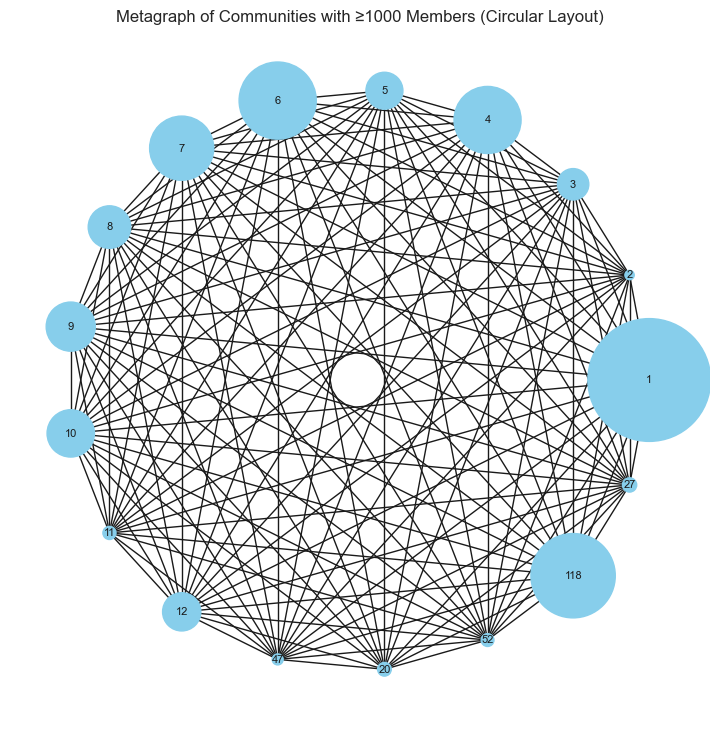

In [100]:
# Set the minimum community size for filtering\
warnings.filterwarnings("ignore", category=UserWarning)
member_size = 1000

# Filter communities with size >= member_size
filtered_communities = {comm: size for comm, size in community_sizes.items() if size >= member_size}
filtered_community_ids = set(filtered_communities.keys())
print(f'Number of communities with {member_size} memebers is: {len(filtered_communities)}')

# Create a metagraph where each node represents a filtered community
metagraph = nx.Graph()

# Add nodes to the metagraph representing each filtered community
for community_id in filtered_community_ids:
    metagraph.add_node(community_id, size=filtered_communities[community_id])

# Add edges between filtered communities if nodes in different communities are connected
for u, v in G_undirected.edges():
    comm_u = partition[u]
    comm_v = partition[v]
    if comm_u in filtered_community_ids and comm_v in filtered_community_ids and comm_u != comm_v:
        if metagraph.has_edge(comm_u, comm_v):
            metagraph[comm_u][comm_v]['weight'] += 0.02
        else:
            metagraph.add_edge(comm_u, comm_v, weight=1)

# Adjust the layout to arrange nodes in a circular pattern
plt.figure(figsize=(7, 7))

# Use circular layout for better visualization of communities
pos = nx.circular_layout(metagraph)

# Scale the node size by community size
sizes = [metagraph.nodes[comm]['size'] * 0.04 for comm in metagraph.nodes()]

# Draw the metagraph with node sizes and circular layout
nx.draw(metagraph, pos, node_size=sizes, with_labels=True, font_size=8, cmap=plt.cm.rainbow, node_color='skyblue')

# Title the plot
plt.title(f"Metagraph of Communities with ≥{member_size} Members (Circular Layout)")

# Show the plot
plt.show()


## Approach 2: Plotting selected communities with all members

In [39]:
def plot_communities_with_members_between(min_member, max_member):
    # Filter communities based on size range (min_member to max_member)
    filtered_communities = {comm: size for comm, size in community_sizes.items() if min_member <= size <= max_member}
    filtered_community_ids = set(filtered_communities.keys())
    print(f'Number of communities with memebers between {min_member} and {max_member} is: {len(filtered_communities)}')
    
    # Filter out the nodes that belong to the selected communities
    nodes_to_plot = [node for node, comm in partition.items() if comm in filtered_community_ids]
    
    # Create a subgraph containing only those nodes
    subgraph = G_undirected.subgraph(nodes_to_plot)
    
    # Create a color map based on the communities of the subgraph
    values = [partition[node] for node in subgraph.nodes()]
    
    # Initialize lists for intra-community (black) and inter-community (red) edges
    intra_edges = []
    inter_edges = []
    
    # Separate intra-community and inter-community edges
    for u, v in subgraph.edges():
        if partition[u] == partition[v]:  # Intra-community edge
            intra_edges.append((u, v))
        else:  # Inter-community edge
            inter_edges.append((u, v))
    
    # Set up the plot
    plt.figure(figsize=(8, 10))
    
    # Layout for visualization
    pos = nx.spring_layout(subgraph)
    
    # Draw nodes with a color map based on community membership
    nx.draw_networkx_nodes(subgraph, pos, node_color=values, node_size=2, cmap=plt.cm.rainbow)
    
    # Draw intra-community edges (black)
    nx.draw_networkx_edges(subgraph, pos, edgelist=intra_edges, edge_color='black', width=0.1)
    
    # Draw inter-community edges (red)
    nx.draw_networkx_edges(subgraph, pos, edgelist=inter_edges, edge_color='red', width=1.0)
    
    # Hide labels for a cleaner visualization
    plt.title(f"Communities with members between {min_member} and {max_member} (Black edges = Intra, Red edges = Inter)")
    plt.show()


Number of communities with memebers between 2500 and 7000 is: 1


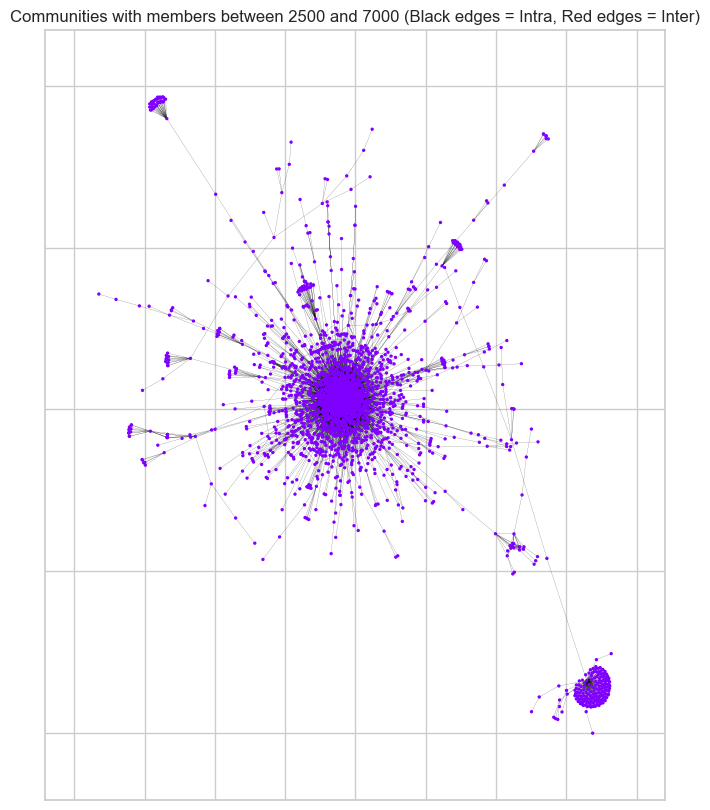

In [41]:
plot_communities_with_members_between(2500, 7000)

Number of communities with memebers between 2000 and 5000 is: 4


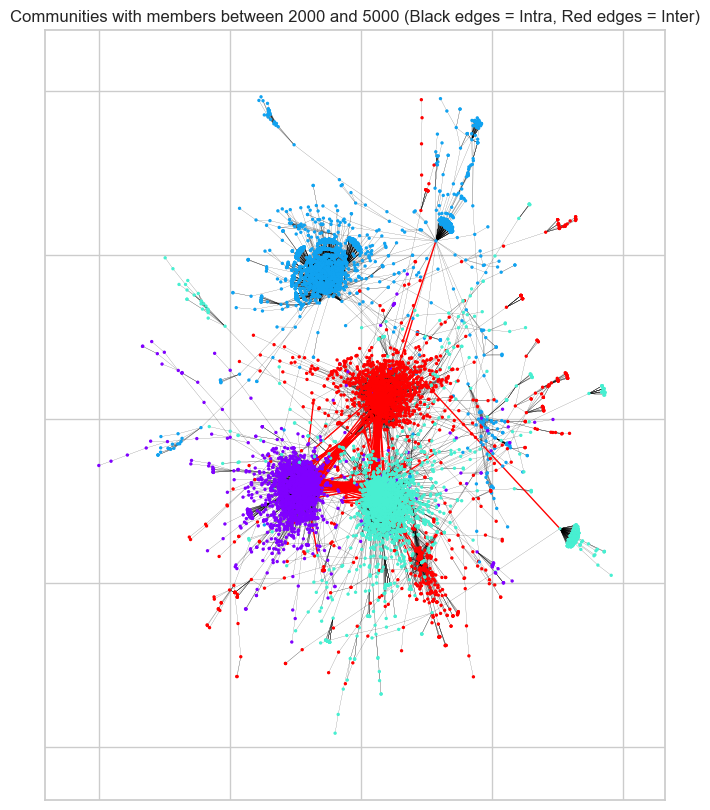

In [42]:
plot_communities_with_members_between(2000, 5000)

#### There is also possible to run this directly in Networkx
#### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html

## Checking modularity and partition_quality

In [56]:
from networkx.algorithms.community.quality import modularity


# Step 1: Group nodes by their community
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = set()
    communities[comm].add(node)

# Convert the dictionary into a list of sets (communities)
communities = list(communities.values())

# Step 2: Compute modularity
mod_value = modularity(G, communities, weight='weight')
print("Modularity:", mod_value)


Modularity: 0.4206776215911069


In [61]:
import networkx as nx
from networkx.algorithms.community.quality import partition_quality

# Convert the partition dictionary to a list of sets (required format for partition_quality)
communities = {}
for node, comm in partition.items():
    if comm not in communities:
        communities[comm] = set()
    communities[comm].add(node)

# Convert to a list of sets
partition_list = list(communities.values())

# Compute the partition quality (coverage and performance)
coverage, performance = partition_quality(G_undirected, partition_list)

# Display the results
print(f"Coverage: {coverage}")
print(f"Performance: {performance}")


Coverage: 0.683853123847788
Performance: 0.8509421462586705


Let's break down what the coverage and performance values mean in the context of your graph and its community structure:
1. Coverage: 0.6839

    Definition: Coverage is the proportion of edges that are entirely within communities (intra-community edges) compared to the total number of edges in the graph.
    Interpretation: A coverage value of 0.6839 means that 68.4% of the edges in your graph are within the communities identified by the partition. This indicates that the majority of the graph’s edges lie within the communities, rather than between them.
    Higher coverage suggests that the detected communities have many internal connections, but 68.4% is a reasonable balance, as some inter-community edges are expected.

2. Performance: 0.8509

    Definition: Performance is the ratio of "correctly classified" edges and non-edges (intra-community edges + inter-community non-edges) to the total number of possible edges in the graph.
    Interpretation: A performance value of 0.8509 means that 85.1% of the edges (and non-edges) in your graph are correctly placed with respect to the community structure. This includes both intra-community edges (which are desirable) and inter-community non-edges (i.e., the absence of connections between communities).
    Higher performance indicates a well-separated community structure, and a value of 85.1% is a good indicator that your graph has a clear community structure with relatively few connections between different communities.

Overall Interpretation:

    Your community detection results show a good partition of the network.
    Coverage (68.4%) indicates that most edges are internal to communities, which means the communities are well-formed but not overly strict in separating all edges.
    Performance (85.1%) is relatively high, suggesting that the partition does a good job in identifying both connections within communities and the absence of connections between different communities.

This means the community structure detected in graph is meaningful, with most of the graph's internal connections concentrated within the detected communities, and relatively few edges between communities.

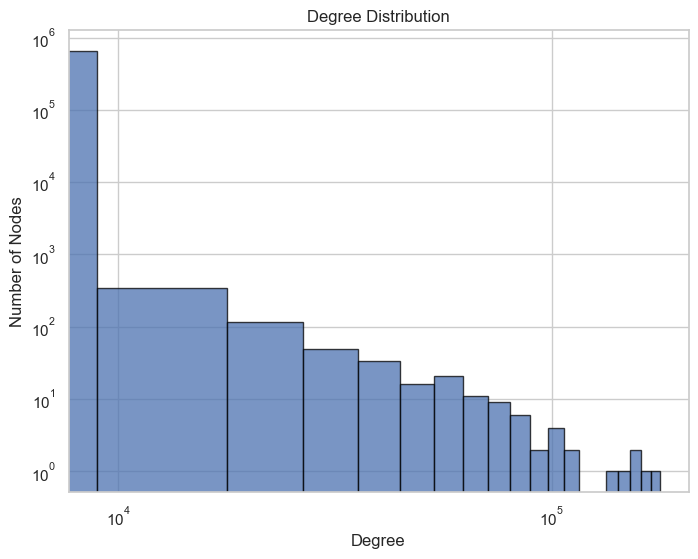

In [63]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a degree dictionary: key=node, value=degree
degree_dict = dict(G.degree())

# Get the degree values
degrees = list(degree_dict.values())

# Create a histogram of the degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, alpha=0.75, color='b', edgecolor='black')

# Add labels and title
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xscale('log')  # Optional: use logarithmic scale for better visualization
plt.yscale('log')  # Optional: use logarithmic scale for better visualization
plt.grid(True)

# Show the plot
plt.show()


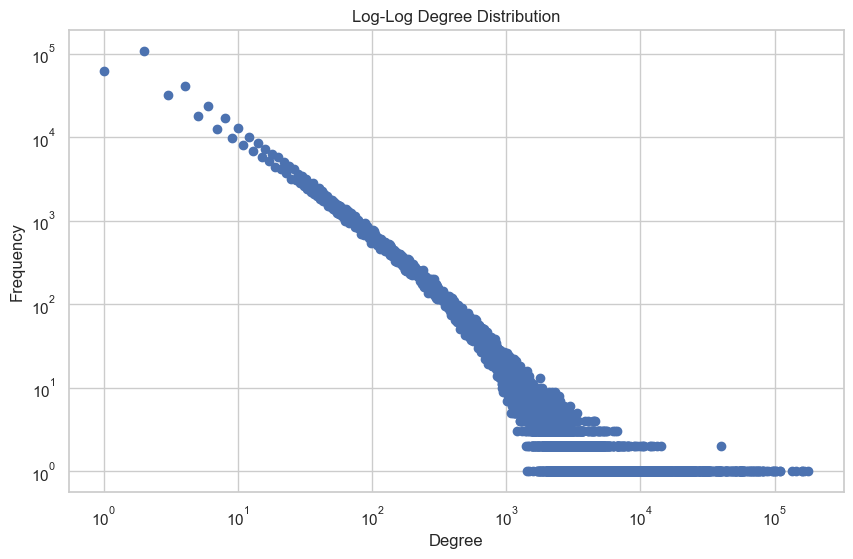

In [64]:
# Calculate the degree distribution
degree_count = nx.degree_histogram(G)
degrees = range(len(degree_count))

# Plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(degrees, degree_count, marker='o', linestyle='None')
plt.title("Log-Log Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

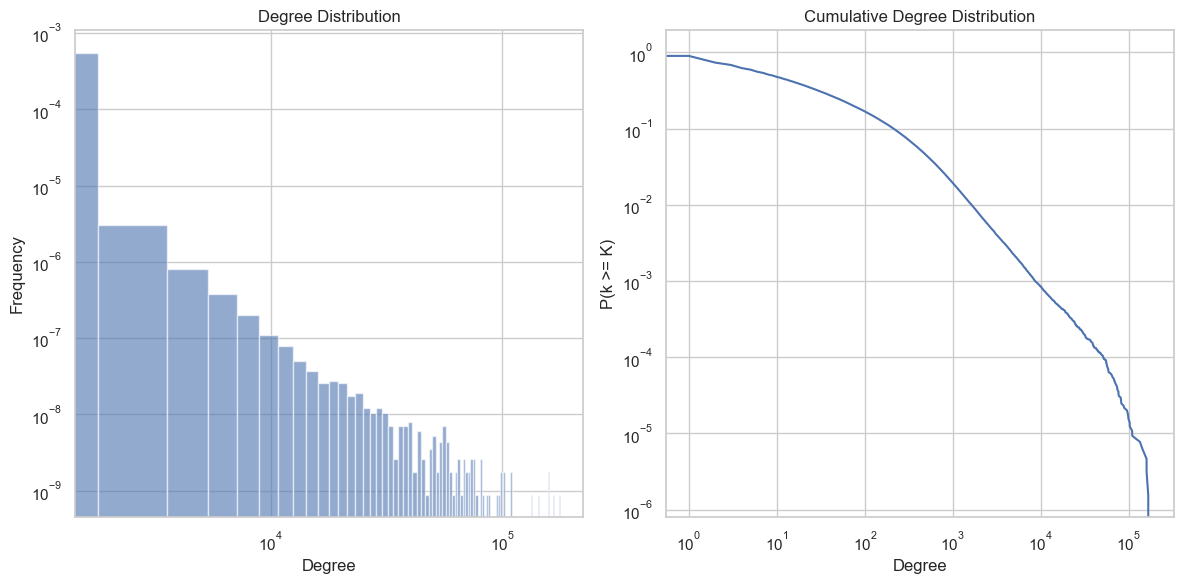

Number of nodes: 645414
Number of edges: 39527559
Average degree: 122.49
Maximum degree: 178290
Minimum degree: 0


In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_degree_distribution(G, scale='log', bins=100):
    # Get degrees of all nodes
    degrees = [d for n, d in G.degree()]
    
    # Count the frequency of each degree
    degree_counts = Counter(degrees)
    
    # Sort the degrees and counts
    x = sorted(degree_counts.keys())
    y = [degree_counts[d] for d in x]
    
    # Calculate cumulative distribution
    cum_y = np.cumsum(y)
    cum_y = cum_y / cum_y[-1]  # Normalize
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot degree distribution
    ax1.hist(degrees, bins=bins, density=True, alpha=0.6)
    ax1.set_title('Degree Distribution')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Frequency')
    if scale == 'log':
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    
    # Plot cumulative degree distribution
    ax2.plot(x, 1 - cum_y, 'b-')
    ax2.set_title('Cumulative Degree Distribution')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('P(k >= K)')
    if scale == 'log':
        ax2.set_xscale('log')
        ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print some basic statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
    print(f"Maximum degree: {max(degrees)}")
    print(f"Minimum degree: {min(degrees)}")

# Assuming your graph is named G
plot_degree_distribution(G)

# If you want to plot in linear scale instead of log scale
# plot_degree_distribution(G, scale='linear')

# If you want to change the number of bins
# plot_degree_distribution(G, bins=50)

## Find similarities for different comunities 

In [93]:
import networkx as nx

def create_subgraph_from_community(G, partition, community_id, file_name_for_graph):

    # Step 1: Identify nodes in the specified community
    community_nodes = [node for node, comm in partition.items() if comm == community_id]
    
    # Step 2: Create the subgraph
    subgraph = G.subgraph(community_nodes).copy()  # Use copy to get a separate graph object
    print(f"Subgraph for community {community_id} has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

    nx.write_gexf(subgraph, f'graph/{file_name_for_graph}.gexf')
    return subgraph

In [94]:
subgraph_3 = create_subgraph_from_community(G, partition, 3, 'subgraph_3')


Subgraph for community 3 has 12776 nodes and 299677 edges.


In [98]:
graph = nx.read_gexf("graph/subgraph_3.gexf")
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 12776
Number of Edges: 299677


In [102]:
subgraph_52 = create_subgraph_from_community(G, partition, 52, 'subgraph_52')

Subgraph for community 52 has 2138 nodes and 25151 edges.


In [103]:
subgraph_11 = create_subgraph_from_community(G, partition, 11, 'subgraph_11')

Subgraph for community 11 has 2240 nodes and 51294 edges.


In [104]:
subgraph_20 = create_subgraph_from_community(G, partition, 20, 'subgraph_20')

Subgraph for community 20 has 2442 nodes and 12395 edges.
